In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
%matplotlib inline
import seaborn as sns
from sqlalchemy import create_engine
import dbcreds

In [2]:
conn = create_engine('postgresql://'+dbcreds.user+':'+dbcreds.password+'@'+dbcreds.host+':5432/'+dbcreds.database)
data = pd.read_sql_table(table_name='movement',con=conn,schema='cascais')
data.head()
#remove all applications id that does not start with an application
data=data[(data['application_id']!=-1)]
#convert the movement data to daytime variabl
from datetime import datetime, timedelta
data.loc[:,'movement_date']= data.loc[:,'movement_date'].apply(
    lambda x: None if x=='' else datetime(year=int(x[0:4]),
                       month=int(x[5:7]),
                       day=int(x[8:10])))
data.head()




,ute_id,movement_date,year_month,application_id,movement_type,movement_subtype,movement_result,movement_index
3,710,2016-12-06,201612,120674,application,DESEMPREGADO-NOVO EMPREGO,,120674
4,710,NaT,201701,120674,convocation,INTERVENÃÃO TÃCNICA,COMPARECEU,248206
5,710,NaT,201702,120674,convocation,OFERTA,NÃO APRESENTADO,250261
6,710,NaT,201702,120674,convocation,OFERTA,ANULADA,250262
7,710,NaT,201704,120674,convocation,GERAL UTENTE,COMPARECEU,255060


In [3]:
#read in the application table and make a datime varialble instad of the string
applications = pd.read_sql_table(table_name='application',con=conn,schema='cascais')
#applications = applications.sort_values(["ute_id","anomes"])
from datetime import datetime, timedelta
applications.loc[:,'date']= applications.loc[:,'candidatura_data'].apply(
    lambda x: None if x=='' else datetime(year=int(x[0:4]),
                       month=int(x[5:7]),
                       day=int(x[8:10])))


/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


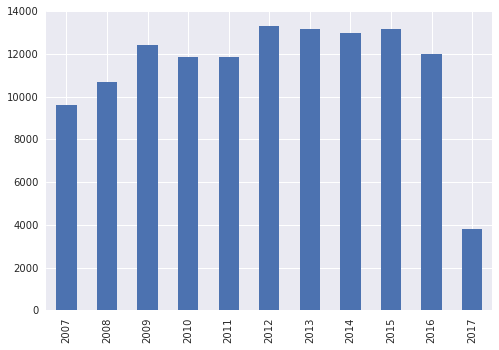

In [4]:
#Find how many applications where submitted each year
applications["year"]=applications["date"].map(lambda x: x.year)
applications=applications[(applications["date"].dt.year>2006)]
applications.year.value_counts(sort=False,ascending=True).plot(kind='bar')

In [5]:
#join the movement table to get the data from the application file togheter with the 
jointTable = pd.merge(data,applications, how='inner', left_on = 'application_id', right_on='table_index')
jointTable.head()

,ute_id_x,movement_date,year_month,application_id,movement_type,movement_subtype,movement_result,movement_index,table_index,anomes,...,conjuge_categoria,conjuge_estado,conjuge_motivo_indisponibilidade,candidatura_categoria_anterior,candidatura_estado_anterior,ute_nr_pessoas_cargo,ute_nr_descendentes_cargo,candidatura_data_ppe,date,year
0,710,2016-12-06,201612,120674,application,DESEMPREGADO-NOVO EMPREGO,,120674,120674,201612,...,None,None,None,2.0,PAS,2.0,2.0,2011-07-19 00:00:00,2016-12-06,2016
1,710,NaT,201701,120674,convocation,INTERVENÃÃO TÃCNICA,COMPARECEU,248206,120674,201612,...,None,None,None,2.0,PAS,2.0,2.0,2011-07-19 00:00:00,2016-12-06,2016
2,710,NaT,201702,120674,convocation,OFERTA,NÃO APRESENTADO,250261,120674,201612,...,None,None,None,2.0,PAS,2.0,2.0,2011-07-19 00:00:00,2016-12-06,2016
3,710,NaT,201702,120674,convocation,OFERTA,ANULADA,250262,120674,201612,...,None,None,None,2.0,PAS,2.0,2.0,2011-07-19 00:00:00,2016-12-06,2016
4,710,NaT,201704,120674,convocation,GERAL UTENTE,COMPARECEU,255060,120674,201612,...,None,None,None,2.0,PAS,2.0,2.0,2011-07-19 00:00:00,2016-12-06,2016


/opt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


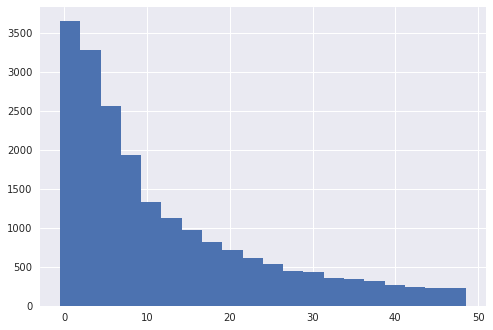

In [6]:
newTable=jointTable[["ute_id_x","application_id","movement_type","movement_subtype","movement_result","movement_date","date"]]
newTableJob=newTable[(newTable["movement_type"]=="cancellation")]
newTableJob["timeFromApplication"]=newTableJob["movement_date"]-newTable["date"]
newTableJob=newTableJob.dropna()
newTableJob=newTableJob[newTableJob["movement_subtype"].str.contains("OUTREM")]
newTableJob["timeFromApplication"]=(newTableJob["timeFromApplication"]/np.timedelta64(1, 'D')).astype(int)
newTableJob["timeFromApplication"]= newTableJob["timeFromApplication"]/12.0
newTableJob["timeFromApplication"].dropna().hist(bins=20,range=[-0.5,48.5])
#newTable.head(100)

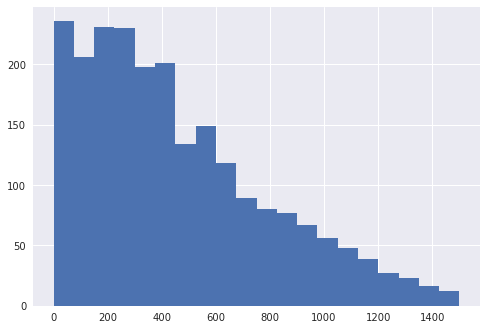

In [8]:
#here we find the time between application and getting a job given that they had intervention of type long term training
#make a smaller table
newTable=jointTable[["ute_id_x","application_id","movement_type","movement_subtype","movement_result","movement_date","date"]]
#find the applications ids that include the long term intervention
find_id=newTable[(newTable["movement_type"]=="intervention")&(newTable["movement_subtype"].str.contains("MODULAR"))]["application_id"].values
newTable=newTable[newTable['application_id'].isin(find_id)]
#find the cancellations that in this data. 
newTable=newTable[newTable["movement_type"]=="cancellation"]
#find time between cancellation and application
newTable["timeFromApplication"]=newTable["movement_date"]-newTable["date"]
newTable=newTable.dropna()
newTable=newTable[newTable["movement_subtype"].str.contains("OUTREM")]
newTable["timeFromApplication"]=(newTable["timeFromApplication"]/np.timedelta64(1, 'D')).astype(int)
newTable["timeFromApplication"].dropna().hist(bins=20,range=[-0.5,1500.5])


,ute_id_x,application_id,movement_type,movement_subtype,movement_result,movement_date,date,timeFromApplication


/opt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 'candidatura_rinsc' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


candidatura_rinsc  candidatura_rinsc
1                  1                    36585
2                  2                      267
3                  3                        6
Name: candidatura_rinsc, dtype: int64

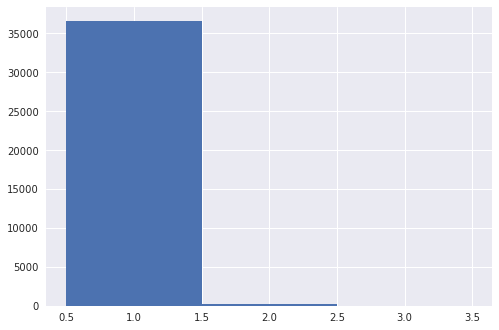

In [33]:
#her we check if one applicants has multiple applications that is not a reapplication
applications.columns
test=applications[["ute_id","candidatura_rinsc"]]
test=test[(test["candidatura_rinsc"]=="N")]
test.groupby("ute_id").ute_id.value_counts()
newFrame=test.groupby("ute_id").candidatura_rinsc.value_counts().hist(bins=3, range=[0.5,3.5])
#newFrame.describe()
newFrame=test.groupby("ute_id").candidatura_rinsc.value_counts().to_frame()
newFrame.groupby("candidatura_rinsc").candidatura_rinsc.value_counts()